In [1]:
import matplotlib.pyplot as plt
import pickle as pkl
import os
import parse
import numpy as np

In [2]:
def bernoulli_sampling_error(num_positive_trials, num_negative_trials, d):
    # Calculate the total number of trials
    num_trials = num_positive_trials + num_negative_trials

    # Calculate the proportion of positive trials
    p = num_positive_trials / num_trials

    # Calculate the standard error
    se = np.sqrt(p * (1 - p) / num_trials)

    # Calculate the 95% confidence interval
    z = 1.96  # Z-score for 95% confidence
    ci = (p - z * se, p + z * se)

    se_d = se / d
    ci_d = (ci[0] / d, ci[1] / d)

    return se_d, ci_d

In [3]:
def load_samples(dir, x_range, meta_key):
    all_samples = []
    data = {}
    for sample_name in os.listdir(dir):
        n, k, d, w = parse.parse('{}-{}-{}-w-{}-samples.pkl', sample_name)
        samples = pkl.load(open(f'{dir}/{sample_name}', 'rb'))
        key = f'[{n}, {k}, {d}] Weight {w}'
        if key not in data:
            data[key] = [(None, None, None) for _ in range(len(x_range))]
        all_samples += samples
        for sample in samples:
            x = sample.json_metadata[meta_key]
            try:
                x_idx = x_range.index(x)
            except ValueError:
                continue
            se, ci = bernoulli_sampling_error(sample.errors, sample.shots - sample.errors, float(d))
            data[key][x_idx] = (1 - np.power(1 - sample.errors / sample.shots, 1 / float(d)), se, ci)
    return data, all_samples

In [4]:
p_range = [0.001, 0.003, 0.005, 0.007]
data, samples = load_samples('results', p_range, 'p')

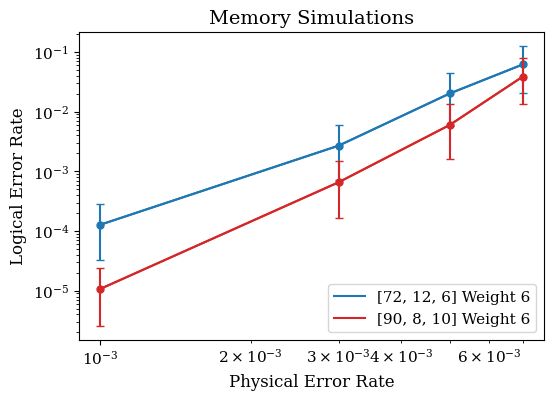

In [5]:
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink']
color_idx = 0

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 11
    })
plt.figure(figsize=(6, 4)) 
for params, results in data.items():
    errs, se, ci = zip(*results)
    ci_lb = [x[0] for x in ci] # Confidence interval lower bound
    ci_ub = [x[1] for x in ci] # Confidence interval upper bound
    n, k, d, _, w = parse.parse('[{}, {}, {}]{}Weight {}', params)
    style = '--' if w == '8' else '-' if w == '6' else '-.'
    plt.plot(p_range, errs, linestyle=style, label=params, color=colors[color_idx])
    plt.plot(p_range, errs, 'o', linestyle=style, markersize=5, color=colors[color_idx])
    plt.errorbar(p_range, errs, yerr=[ci_lb, ci_ub], fmt='none', ecolor=colors[color_idx], capsize=3)
    color_idx += 1
plt.loglog()
plt.legend(loc='lower right')
plt.ylabel('Logical Error Rate', fontsize=12)
plt.xlabel('Physical Error Rate', fontsize=12)
plt.title('Memory Simulations', fontsize=14)
plt.show()